In [7]:
from sunpy.net import Fido, attrs as a
from stixpy.net.client import STIXClient
from sunpy.timeseries import TimeSeries
from stixpy import timeseries
import matplotlib.pyplot as plt
import sys
import matplotlib.dates as mdates
import datetime
import numpy as np
from datetime import date, timedelta
import pandas as pd
import requests
from scipy.io import readsav
from scipy.interpolate import griddata
from scipy import interpolate

In [8]:
#### FINDS AND DOWLOADS SWAVES DATA ####
#### RETURNS A LIST OF STRINGS OF THE OBSERVED DAYS ####

def get_swaves_sav(start_day, end_day, path):

    start_year = int(start_day[0:4])
    start_month = int(start_day[5:7])
    start_day = int(start_day[8:10])
    end_year = int(end_day[0:4])
    end_month = int(end_day[5:7])
    end_day = int(end_day[8:10])
    start_year_str = str(start_year)

    sdate = datetime.date(start_year,start_month,start_day) 
    edate = datetime.date(end_year,end_month,end_day)
    date_list = pd.date_range(sdate,edate - timedelta(days=1), freq='d')

    date_list_strings = []
    for i in range(0, np.size(date_list)):
        date = str(date_list[i])
        start_year_string = str(date[0:4])
        start_month_string = str(date[5:7])
        start_day_string = str(date[8:10])
        date_combined = start_year_string + start_month_string + start_day_string
        date_list_strings.append(date_combined)

    for i in range(0, np.size(date_list_strings)):
        url = 'https://solar-radio.gsfc.nasa.gov/data/stereo/new_summary/' + start_year_str + '/swaves_average_' + date_list_strings[i] + '_a.sav'
        r = requests.get(url, allow_redirects=True)
        open(path + '/swaves_' + date_list_strings[i] + '_a.sav' , 'wb').write(r.content)
    return (date_list_strings)

In [9]:
#### READ THE DOWNLOADED SAV FILES ####
#### RETURN LIST OF FREQUENCIES AND FORMATTED DATA (2-D DYNAMIC SPECTRUM) ####
#### PROVIDE THE PATH TO WHERE THE SAV FIKES WERE DOWNLOADED ####
#### PROVIDE THE LIST OF STRINGS RETURNED FROM get_swaves_sav ####
def read_swaves_sav(path, date_list_strings):

    data_swaves = []
    for i in range(0, np.size(date_list_strings)):
        data = readsav(path + '/swaves_'+ date_list_strings[0]+ '_a.sav')
        data_swaves.append(data)


    proccessed_swaves_arrays = []
    swaves_freqs = data_swaves[0]['frequencies']
    for i in range(0, np.size(date_list_strings)):

        swaves_freqs = data_swaves[i]['frequencies']
        swaves_back = data_swaves[i]['back']
        swaves_spec = data_swaves[i]['spectrum']
        proccessed_swaves_arrays.append(swaves_spec.T) # dont do transpose if doing backsub

    combined_swaves_data =  np.hstack(proccessed_swaves_arrays)

    return (combined_swaves_data, swaves_freqs)

In [10]:
#### PROCESS SWAVES DATA ####
#### RETURNS, DATA, FREQUENCIES, AND DATETIMES ####
def swaves_processing(data, freq, start, end):

	new_data = data.copy()

	# REMOVING FREQUENCY BANDS CONTAINONY ONLY ZEROES
	for i in range (0, new_data.shape[0]):
		if np.mean(new_data[i, :]) == 0:
			new_data[i, :] = np.nan


	# REMOVING VALUES < 0
	new_data[new_data < 0] = np.nan

	
	# CONSTRUCTING DATETIMES
	start_year = int(start[0:4])
	start_month = int(start[5:7])
	start_day = int(start[8:10])
	end_year = int(end[0:4])
	end_month = int(end[5:7])
	end_day = int(end[8:10])
	sdate = datetime.date(start_year,start_month,start_day) 
	edate = datetime.date(end_year,end_month,end_day)

	observation_start_time = datetime.datetime(sdate.year, sdate.month, sdate.day, 0, 0)
	date_list = pd.date_range(sdate,edate - timedelta(days=1), freq='d')
	date_list_strings = []

	for i in range(0, np.size(date_list)):
		date = str(date_list[i])
		start_year_string = str(date[0:4])
		start_month_string = str(date[5:7])
		start_day_string = str(date[8:10])
		date_combined = start_year_string + start_month_string + start_day_string
		date_list_strings.append(date_combined)

	time_res = timedelta(seconds=60)
	swaves_epoch = []
	swaves_epoch.append(observation_start_time)
	for i in range(0, (24 * len(date_list_strings) * 60) - 1):
	    swaves_epoch.append(swaves_epoch[-1] + time_res)

	# PERFORMING INTERPOLATION
	x = np.arange(0, new_data.shape[1])
	y = np.arange(0, new_data.shape[0])
	new_data = np.ma.masked_invalid(new_data)
	xx, yy = np.meshgrid(x, y)

	mean =  np.mean(new_data)
	x1 = xx[~new_data.mask]
	y1 = yy[~new_data.mask]
	newarr = new_data[~new_data.mask]
	GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy), method='cubic', fill_value = mean)

	return (swaves_epoch, freq, GD1)

In [11]:
def get_goes(start, end, path):

	#Getting GOES Data
	goesquery = Fido.search(a.Time(start, end), a.Instrument('goes'))
	goesfiles = Fido.fetch(goesquery, path = path)
	goes_lightcurves = TimeSeries(goesfiles)

	#Concatenate data to represent time range
	combined_ts_goes = goes_lightcurves[0]
	for lcgoes in goes_lightcurves[1:]:
	    combined_ts_goes = combined_ts_goes.concatenate(lcgoes)

	return (combined_ts_goes)
#__________________________________



def get_stix(start, end, path):
	#Getting stix Data
	query = Fido.search(a.Time(start, end), a.Instrument.stix, a.stix.DataProduct.ql_lightcurve)
	files = Fido.fetch(query, path = path)
	ql_lightcurves = TimeSeries(files)


	#Concatenate data to represent time range
	combined_ts = ql_lightcurves[0]
	for lc in ql_lightcurves[1:]:
		combined_ts = combined_ts.concatenate(lc)

	return (combined_ts)

In [12]:
def stix_comparison_summary_plot(start_day, end_day, path, start_time, end_time, ):

	start_str = start_day
	# Getting and processing SWAVES data
	date_list_strings = get_swaves_sav(start_day, end_day, path)
	read_swaves_sav_return = read_swaves_sav(path, date_list_strings)
	swaves_data = read_swaves_sav_return[0]
	freqs = read_swaves_sav_return[1]
	stereo_process_return = swaves_processing(swaves_data, freqs, start_day, end_day)
	swaves_epoch =  stereo_process_return[0]
	freq = stereo_process_return[1]
	GD1 = stereo_process_return[2]


	#Getting GOES Data
	combined_ts_goes = get_goes(start_day, end_day, path)


	#Getting STIX Data
	combined_ts = get_stix(start_day, end_day, path)


	#Formatting
	goes = combined_ts_goes.to_dataframe()
	stix = combined_ts.to_dataframe()
	stix = stix.drop(['control_index', 'timedel', 'triggers', 'triggers_err', 'rcr' ,'4.0-10.0_err' ,'10.0-15.0_err' ,'15.0-25.0_err' ,'25.0-50.0_err', '50.0-84.0_err'], axis=1)


	#Formatting Times
	start_hour = int(start_time[0:2])
	start_minute = int(start_time[3:5])
	start_second = int(start_time[6:8])

	end_hour = int(end_time[0:2])
	end_minute = int(end_time[3:5])
	end_second = int(end_time[6:8])

	start_year = int(start_day[0:4])
	start_month = int(start_day[5:7])
	start_day = int(start_day[8:10])

	end_year = int(end_day[0:4])
	end_month = int(end_day[5:7])
	end_day = int(end_day[8:10])


	#Plotting
	My_FIGURE = plt.figure(figsize=(14.,10.))
	ax1 = plt.subplot2grid((3, 1), (0, 0))
	ax1.xaxis_date()
	date_format = mdates.DateFormatter('%H:%M:%S')
	ax1.xaxis.set_major_formatter(date_format)
	ax1.set_xlim([datetime.datetime(start_year, start_month, start_day, start_hour, start_minute, start_second), datetime.datetime(start_year, start_month, start_day, end_hour, end_minute, end_second)])
	lineObjectsgoes = ax1.plot(goes)
	ax1.set_title('GOES X-ray Flux')
	ax1.set_ylim([10**-9, 10**-2])
	ax1.set_ylabel("Flux (Watts m$^{-2}$)")
	plt.legend(iter(lineObjectsgoes), ('0.5-4 $\AA$', '1-8 $\AA$'), loc='upper right')	
	plt.yscale('log')
	ax1.axes.get_xaxis().set_visible(False)


	ax2 = plt.subplot2grid((3, 1), (1, 0))
	ax2.xaxis_date()
	date_format = mdates.DateFormatter('%H:%M:%S')
	ax2.xaxis.set_major_formatter(date_format)
	ax2.set_xlim([datetime.datetime(start_year, start_month, start_day, start_hour, start_minute, start_second), datetime.datetime(start_year, start_month, start_day, end_hour, end_minute, end_second)])
	lineObjects = ax2.plot(stix, label = stix.columns)
	ax2.set_title('STIX X-ray Flux')
	ax2.set_ylim([1, 1000000])
	ax2.set_ylabel("Counts$^{-1}$ keV$^{-1}$")
	plt.legend(iter(lineObjects), ('4.0-10.0 keV', '10.0-15.0 keV', '15.0-25.0 keV', '25.0-50.0 keV', '50.0-84.0 keV'), loc='upper right')	
	plt.yscale('log')
	ax2.axes.get_xaxis().set_visible(False)


	ax3 = plt.subplot2grid((3, 1), (2, 0))
	ax3.pcolormesh(swaves_epoch, freq, GD1,  cmap = 'viridis', vmin = np.percentile(GD1, 1), vmax = np.percentile(GD1, 99))
	ax3.xaxis_date()
	date_format = mdates.DateFormatter('%H:%M:%S')
	ax3.xaxis.set_major_formatter(date_format)
	plt.xlabel("Time (UT) " + start_str[0:10])
	plt.ylabel("Frequency (kHz)")
	ax3.set_title('STEREO WAVES Radio Emission')
	ax3.set_xlim([datetime.datetime(start_year, start_month, start_day, start_hour, start_minute, start_second), datetime.datetime(start_year, start_month, start_day, end_hour, end_minute, end_second)])
	plt.ylim(freq.max(), freq.min())
	plt.yscale('log')
	My_FIGURE.tight_layout()
	My_FIGURE.savefig(path + "/STIX_PLOT.png")

/Users/thomas/opt/miniconda3/lib/python3.9/site-packages/astropy/table/table.py:3409: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
Files Downloaded: 100%|█████████████████████████| 2/2 [00:00<00:00, 15.14file/s]
/var/folders/nh/6r_l73vn5p1cbcbs3y1lp8j80000gn/T/ipykernel_30095/3948480606.py:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax3.pcolormesh(swaves_epoch, freq, GD1,  cmap = 'viridis', vmin = np.percentile(GD1, 1), vmax = np.percentile(GD1, 99))


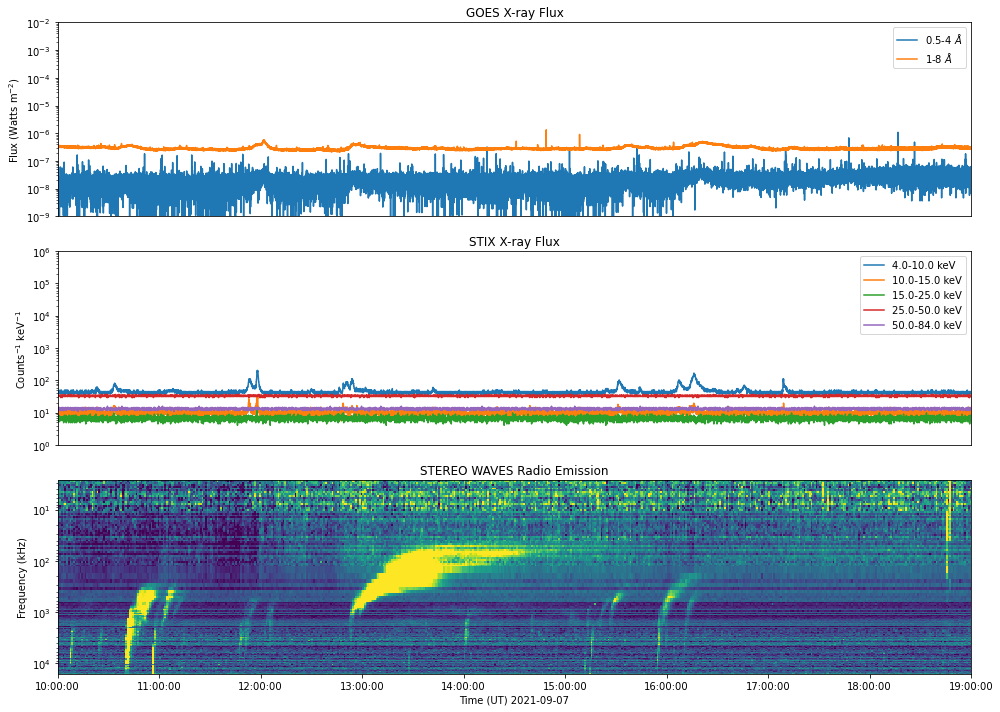

In [13]:
# start_day_sample = '2020-06-06'
# end_day_sample = '2020-06-07'

start_day_sample = '2021-09-07'
end_day_sample = '2021-09-08'

sample_path = '/Users/thomas/SS Research Project'
start_time_sample = '10:00:00'
end_time_sample = '19:00:00'

stix_comparison_summary_plot(start_day_sample, end_day_sample, sample_path, start_time_sample, end_time_sample)
plt.show()